In [77]:
import numpy as np
import matplotlib.pyplot as plt
import json
import copy
from tabulate import tabulate

# @brief Load a single json file
# @param filename The filename of the json file
# @return The json file as a dictionary
def load_single_json_file(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    return data

# @brief Load multiple json files
# @param filenames The list of filenames to load
# @return A list of dictionaries, each representing a json file
def load_json_files(filenames):
    data = []
    for filename in filenames:
        data.append(load_single_json_file(filename))
    return data

# @brief find all filenames in a directory
# @param directory The directory to search
# @return A list of filenames in the directory
#
# This function shall search in a directory for all  
# files that end with the *.data extension. It will
# return a list of all filenames found.
def find_all_files(directory):
    import os
    files = os.listdir(directory)
    files = [f for f in files if f.endswith('.data')] 
    files = [os.path.join(directory, f) for f in files]
    return files


# @brief find and read all files
# @param directory The directory to search
# @return A list of dictionaries, each representing a json file
def get_data(directory):
    files = find_all_files(directory)
    # display the files
    data = load_json_files(files)
    # display the data
    #for d in data:
    #    print(d)
    
    return data

#test_load_file_data = get_data('data')

# @brief Define the BER range
# @param min_pe The minimum value of the BER
# @param max_pe The maximum value of the BER
# @return The list of BER values
def define_BER_range(min_pe=1e-6, max_pe=0.5):
    ber_range = (min_pe, max_pe)
    Pe_list = np.logspace(np.log10(ber_range[0]), np.log10(ber_range[1]), num=100)
    return Pe_list

# @brief Define the Plot of the PUE vs BER
# @param min_pe The minimum value of the BER
# @param max_pe The maximum value of the BER
# @return The list of BER values and the axis of the plot
def define_plot():
    
    
    # there shall be 6 different plots 
    # left column direct calculation
    # middel column Parity Error Check - direct calculation
    # right column Parity Error Check - v2
    # first row CRC-8 
    # second row CRC-16
    # fourth row CRC-32
    fig, ax = plt.subplots(3, 3, figsize=(15, 15))
    plt.legend()
    plt.grid(True)
    # add horizontal line for worst case for each CRC type 
    R_worst_8 = 1/(2**8)
    R_worst_16 = 1/(2**16)
    R_worst_32 = 1/(2**32)
    ax[0,0].axhline(R_worst_8, color='r')  # Add horizontal line worst case
    ax[0,1].axhline(R_worst_8, color='r')  # Add horizontal line worst case
    ax[0,2].axhline(R_worst_8, color='r')  # Add horizontal line worst case
    ax[1,0].axhline(R_worst_16, color='r')  # Add horizontal line worst case
    ax[1,1].axhline(R_worst_16, color='r')  # Add horizontal line worst case
    ax[1,2].axhline(R_worst_16, color='r')  # Add horizontal line worst case
    ax[2,0].axhline(R_worst_32, color='r')  # Add horizontal line worst case
    ax[2,1].axhline(R_worst_32, color='r')  # Add horizontal line worst case
    ax[2,2].axhline(R_worst_32, color='r')  # Add horizontal line worst case

    # name each subplot
    ax[0,0].set_title('CRC-8 Direct Calculation')
    ax[0,1].set_title('CRC-8 Parity Error Check Direct Approach')
    ax[0,2].set_title('CRC-8 Parity Error Check Direct Approach V2')
    ax[1,0].set_title('CRC-16 Direct Calculation')
    ax[1,1].set_title('CRC-16 Parity Error Check Direct Approach')
    ax[1,2].set_title('CRC-16 Parity Error Check Direct Approach V2')
    ax[2,0].set_title('CRC-32 Direct Calculation')
    ax[2,1].set_title('CRC-32 Parity Error Check Direct Approach')
    ax[2,2].set_title('CRC-32 Parity Error Check Direct Approach V2')

    
    # set y-axis limits for all subplots
    #for i in range(3):
    #    ax[i,0].set_ylim(1e-21,1e-7)
        #for j in range(2):
        #    ax[i,j].set_ylim(1e-21,1e-7)
        #    #ax[i,j].set_ylabel('Probability of Undetected Error (PUE)')
        #    ax[i,j].set_xlabel('Bit Error Rate (BER)')
            


    plt.title('PUE vs BER for Different CRC Codes')
    plt.ylabel('Probability of Undetected Error (PUE)')
    plt.xlabel('Bit Error Rate (BER)')

    return ax

# @brief Create the label for the plot
# @param raw_data The raw data from the json file
# @return The label for the plot
def creat_label(raw_data):
    # label shall have to format "n:<n> <polynom> <Initial>"
    n = raw_data['nBits']
    polynom = raw_data['Polynomial']
    initial = raw_data['Initial'] 
    label = "n:{} {} {}".format(n, polynom, initial)

    return label


# @brief Add curve to a subplot
# @param Pe_list The list of BER values
# @param data The data to plot
# @param ax The axis to plot on
def add_data_toPlot(Pe_list, data, ax):
    # extract lable
    label = data['label'] 
    # extract axis via CRC type and Method
    #row = data['CRC']/8 - 1 # does not work for CRC-32 
    if data['CRC'] == 8:
        row = 0
    elif data['CRC'] == 16:
        row = 1
    else:
        row = 2
    
    if data['Method'] == 'direct':
        col = 0
    elif data['Method'] == 'direct_parityMatrix':
        col = 1
        # workaround till version 1 vs 2 is understood 
        ax[row, col+1].loglog(Pe_list, data['PUE_v2'], label=label)
        print("PUE Matrix: ", data['PUE'])
    else: 
        assert False, "Method not known"
        col = 10

    # define subplot ax 
    ax[row, col].loglog(Pe_list, data['PUE'], label=label)
    
    

## Probability of Undetected Error

Consider a binary $(n,k)$ linear code $C$ where $n$ equals the codeword lenght and $k$ the dataword length. Let $R$ denote the probability of undetected error and $P$ the transition probability.  

According to https://sci-hub.yt/10.1109/tcom.1985.1096340

$$ R(P) = \sum_{i=1}^n{A[i] \cdot P^i \cdot (1-P)^{n-i}}$$ 

$$\{A_i:0 \leq i \leq n\}$$

The weight distribution of its dual shall be denoted as $B_i$ 

According to [Error Control Coding by Shu Lin] page 77

$$ R(P) =  \biggl(2^{-(n-k)} \cdot \sum_{i=0}^{n}{B_i\cdot(1-2\cdot P)^i  \biggr) -(1-P)^n}$$

$$\{B_i:0 \leq i \leq n\}$$

The weights $A$ and $B$ are related via the MacWilliams identity


In [78]:
# @brief Probability of undetected error calculation
#
# This function calculates the probability of undetected error
# @param P probability of error
# @param A array of coefficients
# @param n number of elements in A
# @return probability of undetected error
def ProbabilityOfUndetectedError(P, A, n):
    sum_buffer = 0.0
    for i in range(1,n+1):
        # single element
        buffer = (1 - P) ** (n - i)
        buffer *= (P ** i)
        buffer *= A[i]
        sum_buffer += buffer

    return sum_buffer

# @brief Probability of undetected error calculation with dual probability
#
# This function calculates the probability of undetected error
# @param P probability of error
# @param B array of coefficients
# @param n number of elements in B
# @param k additional parameter for calculation
# @return probability of undetected error
def ProbabilityOfUndetectedError_dual(P, B, n, k):
    sum_buffer = 0.0
    for i in range(n + 1):
        # single element
        buffer = (1 - 2 * P) ** i
        buffer *= B[i]
        sum_buffer += buffer

    buffer = 2 ** (-(n - k)) * sum_buffer
    buffer -= (1 - P) ** n
    return buffer
    

# @brief Get the PUE of a single BER
# @param data single dictonary entry
# @param P single BER
def get_single_PUE(data,BER):
    data_ = copy.deepcopy(data)
    
    PUE = 0

    try:
        # decide the method 
        if data_['Method'] == 'direct':
            # calculate the PUE via the direct method
            
            PUE = ProbabilityOfUndetectedError(BER, data_['Data'], data_['nBits'])
        elif data_['Method'] == 'direct_parityMatrix':
            # calculate the PUE via Parity Error Check - Matrix
            PUE = ProbabilityOfUndetectedError_dual(BER, data_['Data'], data_['nBits'], data_['kBits'])
        else:
            assert False, "Method not known"
            PUE = 0
    except OSError as err:
        print("OS error:", err)
    except ValueError:
        print("Could not convert data to an integer.")
    except Exception as err:
        print(f"Unexpected {err=}, {type(err)=}")
    except:
        print("Unexpected error:", sys.exc_info()[0])
        print(data_)

    return PUE


# @brief Get the PUE
# @param P The list of P values
# @param data-dictonary list
# @return data-dictonary list with PUE values
def get_PUE(data, P):
    # add PUE to data dictionary
    data['PUE'] = []

    for e in P:
        PUE = get_single_PUE(data,e)
        data['PUE'].append(PUE)
        
    
    data['label'] = creat_label(data)
    
    R_01 = get_single_PUE(data, 0.01)
    R_001 = get_single_PUE(data, 0.001)
    
    return data , [R_01,R_001]



## List data

In [79]:
# 1. Load the data
raw_data = get_data('data')

# 2. Loop through and search for 
#   - CRC-32
#   - Polynom: 0xf1922815
#   - Initial: 0xffffffff
#   - InputReflected: true
#   - ResultReflected: true
#   - FinalXOR: true
#   - Method: direct

for raw in raw_data:
    if raw['CRC'] == 32 and raw['Polynomial'] == 0xf1922815 and raw['Initial'] == 0xffffffff and raw['InputReflected'] == True and raw['ResultReflected'] == True and raw['FinalXOR'] == True and raw['Method'] == 'direct':
        # if found check with resulting value given by Norm 61784-3:2021
        print("Correct would be 1.3290758*(10**(-14))")
        print("But we do not get this value")


In [80]:

# 2. loop through different data sets
col_head = ["CRC", "Ref[in]", "Ref[out]", "nBits", "Polynom", "PUE(0.01)", "PUE(0.001)", "Method"]
row_data = []
for raw in raw_data:
    #description = "CRC{}\t| Refl[in:{}|out:{}] | nBits:{}\t| Poly:{}".format(raw['CRC'], raw['InputReflected'], raw['ResultReflected'], raw['nBits'], raw['Polynomial'])

    R_01 = get_single_PUE(raw, 0.01)
    R_001 = get_single_PUE(raw, 0.001)

    col_last = raw['Method']

    row_data.append([raw['CRC'], raw['InputReflected'], raw['ResultReflected'], raw['nBits'], raw['Polynomial'], R_01, R_001, col_last])

    #print("Weight: ", raw['Data'])
    #print("PUE(0.01)= ", R_01 * 1.0)
    #print("PUE(0.001)= ", R_001)

# 3. print the data in a nice way
print(tabulate(row_data, headers=col_head, tablefmt="grid"))


+-------+-----------+------------+---------+------------+-------------+--------------+---------------------+
|   CRC | Ref[in]   | Ref[out]   |   nBits | Polynom    |   PUE(0.01) |   PUE(0.001) | Method              |
+=======+===========+============+=========+============+=============+==============+=====================+
|    16 | True      | True       |      32 | 0x1021     | 1.23477e-11 |  1.55895e-17 | direct              |
+-------+-----------+------------+---------+------------+-------------+--------------+---------------------+
|    16 | True      | True       |      32 | 0x1021     | 1.20794e-07 |  1.55581e-11 | direct_parityMatrix |
+-------+-----------+------------+---------+------------+-------------+--------------+---------------------+
|    16 | True      | True       |      32 | 0x8005     | 5.66773e-15 |  7.02931e-23 | direct              |
+-------+-----------+------------+---------+------------+-------------+--------------+---------------------+
|    16 | True     

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Weight:  [0, 0, 0, 0, 0, 0, 16, 0, 344, 0, 2041, 0, 6704, 0, 14436, 0, 18480, 0, 14366, 0, 6768, 0, 2020, 0, 344, 0, 17, 0, 0, 0, 0, 0, 0]
PUE(0.01)=  1.2347734027691038e-11
PUE(0.001)=  1.5589494478399154e-17
adding  n:32 0x1021 0x89ec  to subplot 0,  0
PUE direct:  [1.5999584005543936e-35, 3.544044872806786e-35, 7.850358794193144e-35, 1.738919755763282e-34, 3.8518492433837695e-34, 8.53215394848917e-34, 1.8899386188304094e-33, 4.1863571438213355e-33, 9.273087329182591e-33, 2.0540539679841732e-32, 4.549866932622035e-32, 1.0078242237640541e-31, 2.232389835094599e-31, 4.9448634713182915e-31, 1.0953110295389002e-30, 2.426159484593057e-30, 5.374026209641097e-30, 1.1903606391397555e-29, 2.6366679755134403e-29, 5.840232967233188e-29, 1.293607227207829e-28, 2.8653117466046163e-28, 6.346555955695064e-28, 1.4057259997806664e-27, 3.1135729975817334e-27, 6.896244393787775e-27, 1.527428095391591e-26, 3.383005241283403e-26, 7.492684537816153e-26, 1.6594497191818835e-25, 3.6752041527822455e-25, 8.13

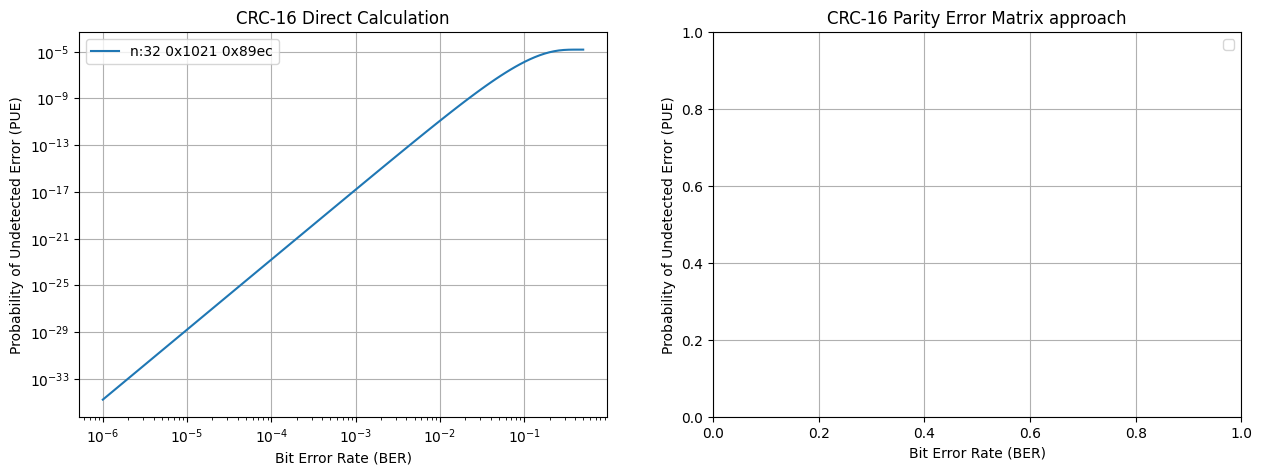

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Weight:  [1, 0, 0, 0, 2, 26, 39, 78, 197, 422, 963, 1826, 3146, 5156, 7254, 8876, 9564, 8876, 7254, 5156, 3146, 1826, 963, 422, 197, 78, 39, 26, 2, 0, 0, 0, 1]
PUE(0.01)=  1.207936122238351e-07
PUE(0.001)=  1.555811035558463e-11
PUE Matrix:  [1.887379141862766e-15, -1.1102230246251565e-16, 1.887379141862766e-15, 0.0, 0.0, 0.0, 0.0, -1.6653345369377348e-15, -1.1102230246251565e-16, 0.0, 0.0, 0.0, 0.0, 0.0, 2.220446049250313e-16, 0.0, 1.5543122344752192e-15, 1.887379141862766e-15, 0.0, -1.6653345369377348e-15, 0.0, 1.7763568394002505e-15, 1.7763568394002505e-15, 1.887379141862766e-15, -1.1102230246251565e-16, -1.887379141862766e-15, -1.1102230246251565e-16, -1.887379141862766e-15, 1.1102230246251565e-16, 1.7763568394002505e-15, 1.1102230246251565e-16, 1.887379141862766e-15, 1.9984014443252818e-15, 8.881784197001252e-16, 9.992007221626409e-16, 3.4416913763379853e-15, 5.10702591327572e-15, 3.4416913763379853e-15, 7.216449660063518e-15, 1.3655743202889425e-14, 2.5979218776228663e-14, 4.2077

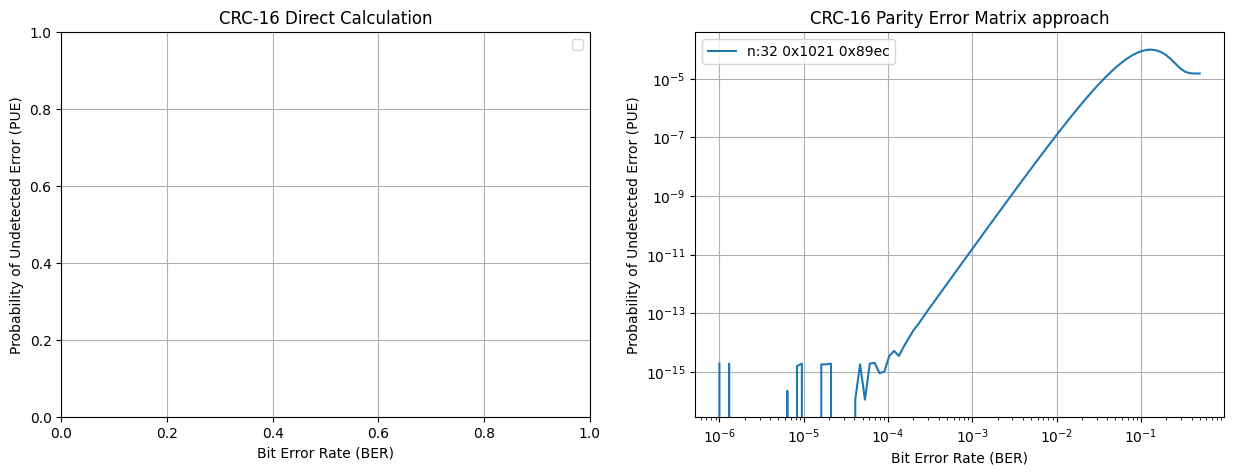

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Weight:  [0, 0, 0, 0, 0, 0, 0, 0, 72, 0, 1353, 0, 7380, 0, 16231, 0, 18408, 0, 12786, 0, 6304, 0, 2246, 0, 592, 0, 149, 0, 12, 0, 3, 0, 0]
PUE(0.01)=  5.667734713196295e-15
PUE(0.001)=  7.029305058572443e-23
adding  n:32 0x8005 0x0  to subplot 0,  0
PUE direct:  [7.199827202122476e-47, 2.078947033394592e-46, 6.0029477965860805e-46, 1.7333468257456032e-45, 5.005023251658046e-45, 1.4451948913154428e-44, 4.172980739055206e-44, 1.2049414279380825e-43, 3.479245136727184e-43, 1.0046240987800361e-42, 2.900825136285956e-42, 8.376041453200848e-42, 2.4185512676616396e-41, 6.983463665105678e-41, 2.016440587595603e-40, 5.822356721901737e-40, 1.6811669764815748e-39, 4.8542413096421485e-39, 1.4016194881474368e-38, 4.0470344341922616e-38, 1.1685341154281196e-37, 3.373986141879204e-37, 9.741867675375874e-37, 2.8127929895591222e-36, 8.121372839391219e-36, 2.3448588828862265e-35, 6.770160008788628e-35, 1.9546787856894613e-34, 5.643457970436252e-34, 1.6293248756160364e-33, 4.7039372067488286e-33, 1.35801

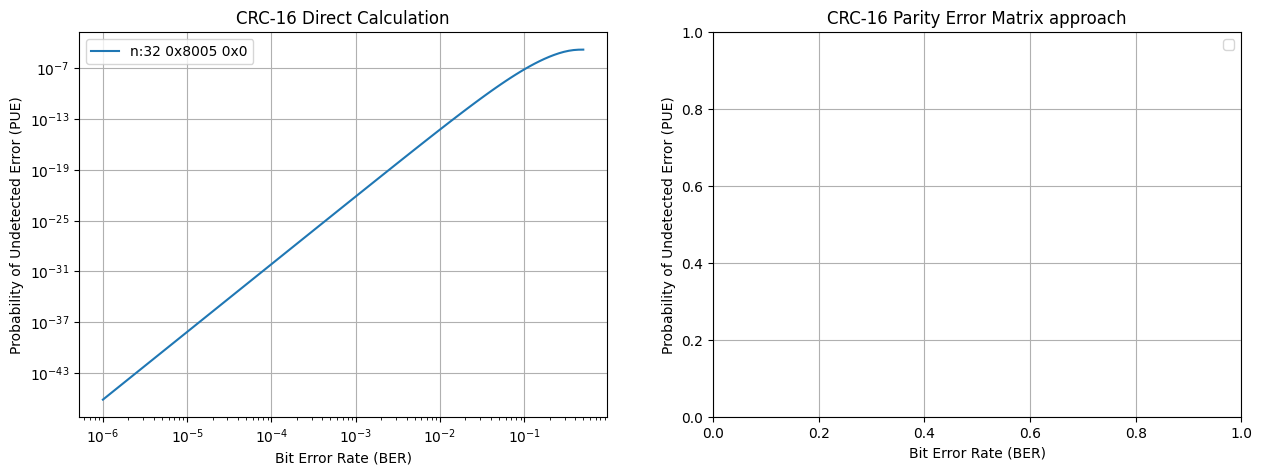

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Weight:  [1, 0, 0, 11, 13, 15, 59, 120, 192, 340, 759, 1733, 3339, 5441, 7502, 8724, 9038, 8724, 7502, 5441, 3339, 1733, 759, 340, 192, 120, 59, 15, 13, 11, 0, 0, 1]
PUE(0.01)=  1.8126434797594015e-07
PUE(0.001)=  2.3337110022225716e-11
PUE Matrix:  [1.7763568394002505e-15, 0.0, 1.7763568394002505e-15, 0.0, -1.1102230246251565e-16, -2.220446049250313e-16, -1.1102230246251565e-16, -1.887379141862766e-15, 0.0, 1.1102230246251565e-16, 0.0, -1.1102230246251565e-16, 0.0, -1.1102230246251565e-16, 1.1102230246251565e-16, 0.0, 1.5543122344752192e-15, 1.887379141862766e-15, -1.1102230246251565e-16, -1.887379141862766e-15, 0.0, 1.9984014443252818e-15, 1.9984014443252818e-15, 2.1094237467877974e-15, 1.1102230246251565e-16, -1.7763568394002505e-15, -1.1102230246251565e-16, -1.5543122344752192e-15, 2.220446049250313e-16, 1.887379141862766e-15, 3.3306690738754696e-16, 1.7763568394002505e-15, 2.220446049250313e-15, 1.2212453270876722e-15, 1.4432899320127035e-15, 4.218847493575595e-15, 6.3282712403633

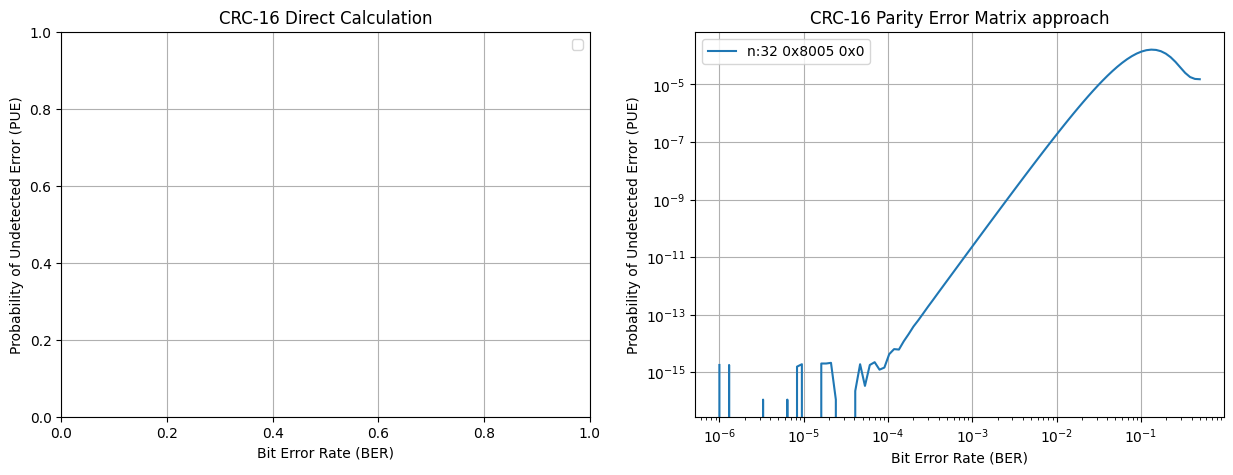

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Weight:  [0, 0, 0, 0, 0, 0, 0, 0, 92, 0, 1467, 0, 7068, 0, 16212, 0, 18745, 0, 12818, 0, 6052, 0, 2356, 0, 530, 0, 171, 0, 24, 0, 0, 0, 1]
PUE(0.01)=  7.24000459849426e-15
PUE(0.001)=  8.98186418352505e-23
adding  n:32 0x8005 0xffffffff  to subplot 0,  0
PUE direct:  [9.199779202685869e-47, 2.65643232043879e-46, 7.670433295600675e-46, 2.2148320551054192e-45, 6.395307488177169e-45, 1.8466379166610615e-44, 5.332142055384969e-44, 1.5396473801150784e-43, 4.4457021190459075e-43, 1.2836863484014493e-42, 3.706609896215928e-42, 1.0702719634082962e-41, 3.0903710640225685e-41, 8.923314682393571e-41, 2.5765629727388316e-40, 7.439678032411941e-40, 2.1481578028569996e-39, 6.202641671831913e-39, 1.7909582342529357e-38, 5.171210663646002e-38, 1.4931269244162418e-37, 4.311204511412765e-37, 1.2447942017562517e-36, 3.594124370999408e-36, 1.037730972210306e-35, 2.9962085661336585e-35, 8.650759986979619e-35, 2.4976451059206448e-34, 7.211085150095822e-34, 2.0819151059147173e-33, 6.010586382191397e-33, 1.73

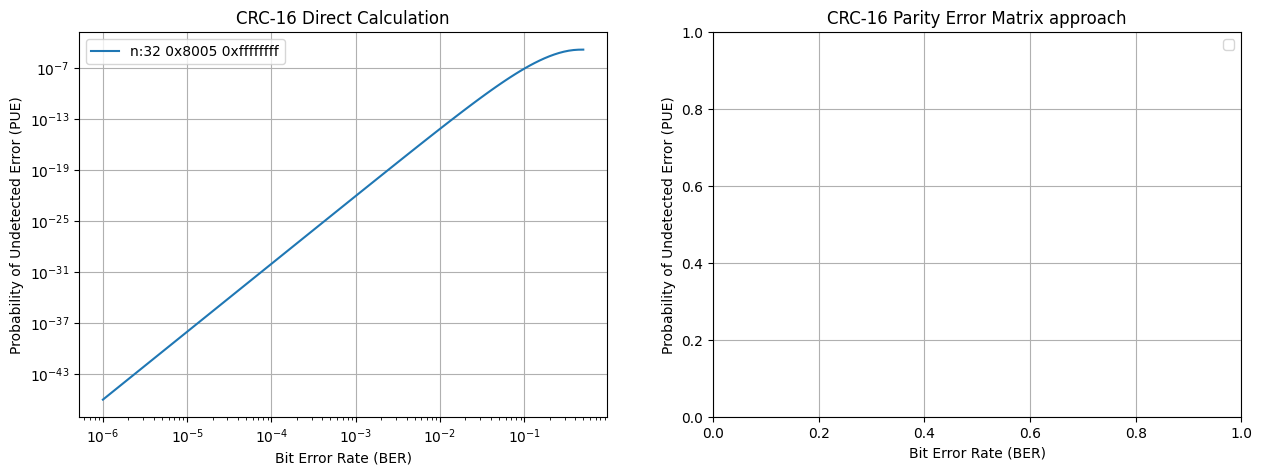

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Weight:  [1, 0, 0, 11, 13, 15, 59, 120, 192, 340, 759, 1733, 3339, 5441, 7502, 8724, 9038, 8724, 7502, 5441, 3339, 1733, 759, 340, 192, 120, 59, 15, 13, 11, 0, 0, 1]
PUE(0.01)=  1.8126434797594015e-07
PUE(0.001)=  2.3337110022225716e-11
PUE Matrix:  [1.7763568394002505e-15, 0.0, 1.7763568394002505e-15, 0.0, -1.1102230246251565e-16, -2.220446049250313e-16, -1.1102230246251565e-16, -1.887379141862766e-15, 0.0, 1.1102230246251565e-16, 0.0, -1.1102230246251565e-16, 0.0, -1.1102230246251565e-16, 1.1102230246251565e-16, 0.0, 1.5543122344752192e-15, 1.887379141862766e-15, -1.1102230246251565e-16, -1.887379141862766e-15, 0.0, 1.9984014443252818e-15, 1.9984014443252818e-15, 2.1094237467877974e-15, 1.1102230246251565e-16, -1.7763568394002505e-15, -1.1102230246251565e-16, -1.5543122344752192e-15, 2.220446049250313e-16, 1.887379141862766e-15, 3.3306690738754696e-16, 1.7763568394002505e-15, 2.220446049250313e-15, 1.2212453270876722e-15, 1.4432899320127035e-15, 4.218847493575595e-15, 6.3282712403633

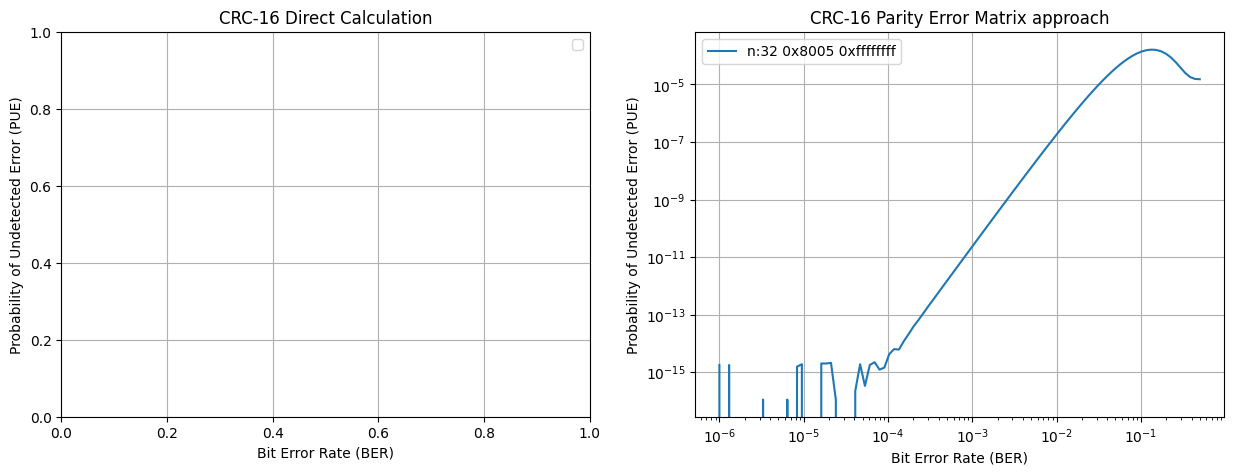

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Weight:  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 25, 64, 237, 760, 2073, 5898, 16136, 41553, 101130, 233305, 512256, 1071554, 2142466, 4099708, 7476041, 13027938, 21713987, 34614826, 52850283, 77222312, 108092563, 145040545, 186468283, 229831315, 271627223, 307828124, 334586062, 348841378, 348891488, 334641242, 307847768, 271604097, 229779609, 186444054, 145043873, 108144430, 77244757, 52830398, 34603636, 21707017, 13032666, 7475515, 4098554, 2146468, 1071315, 511594, 232551, 100890, 41803, 16336, 6079, 2090, 711, 215, 65, 19, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
PUE(0.01)=  0.10864441119428614
PUE(0.001)=  0.02953267869856313
PUE Matrix:  [3.299633720899031e-05, 3.767248374653143e-05, 4.301122450345307e-05, 4.910641770594637e-05, 5.6065208061228944e-05, 6.400990481558733e-05, 7.308012457563073e-05, 8.343523581300083e-05, 9.525714729907708e-05, 

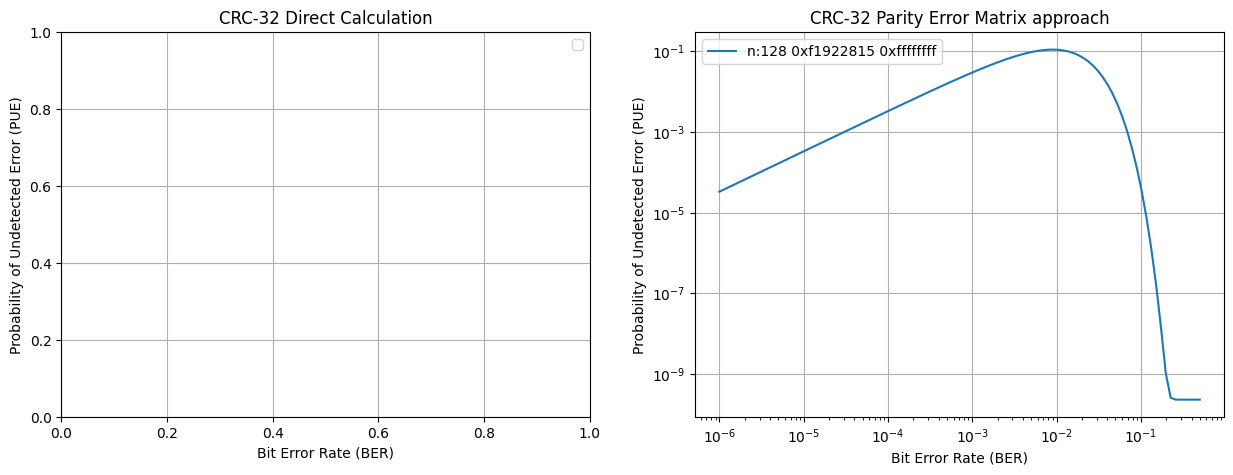

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Weight:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 48, 162, 811, 3089, 10849, 37420, 114055, 319912, 838839, 2032215, 4567678, 9570501, 18706981, 34157140, 58359516, 93390310, 140062072, 197088140, 260477590, 323406494, 377261502, 413706028, 426695855, 413842688, 377232878, 323248158, 260491900, 197222894, 140074030, 93318652, 58349428, 34180959, 18703664, 9567066, 4571575, 2029665, 839665, 321752, 112633, 37264, 11267, 2947, 782, 189, 29, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
PUE(0.01)=  2.0150342020775662e-18
PUE(0.001)=  2.885007226571896e-27
adding  n:64 0x4c11db7 0xffffffff  to subplot 0,  0
PUE direct:  [2.999883002024976e-54, 9.889858974269832e-54, 3.2604349514309157e-53, 1.0748815115606605e-52, 3.543604154414905e-52, 1.1682325564013252e-51, 3.851348597078619e-51, 1.269684138521612e-50, 4.185793555703107e-50, 1.3799363512794116e-49, 4.549244964600523e-49, 1.499748613209958e-48, 4.944203460326278e-48, 1.6299442008121914e-47, 5.373378959205785e-47, 1.7714149166882236e-46, 5.839705528836289e-46, 1.92

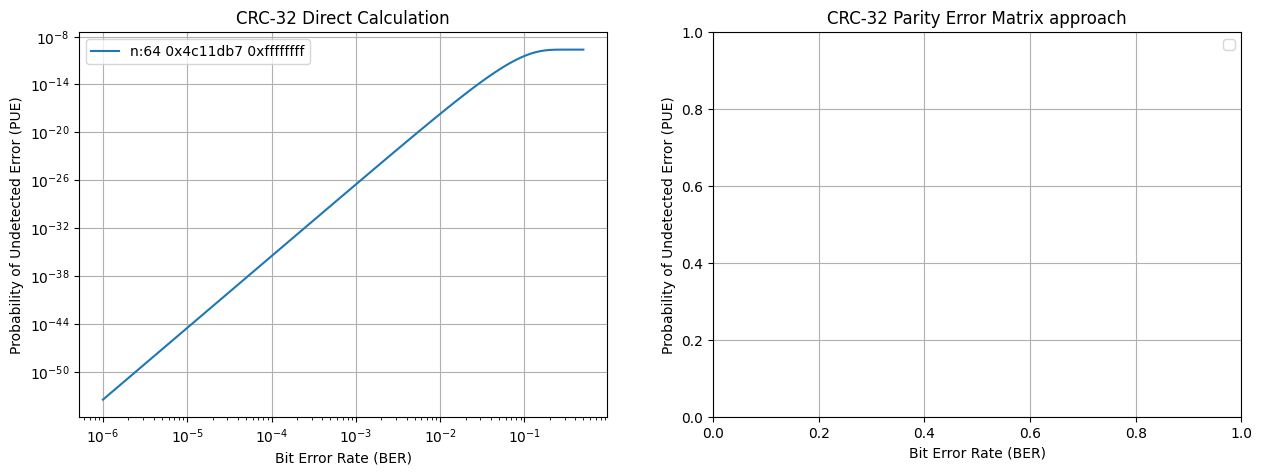

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Weight:  [1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 36, 180, 737, 2953, 10893, 37489, 114089, 320762, 838886, 2031429, 4571269, 9568511, 18697224, 34157735, 58368061, 93398926, 140046804, 197067600, 260524414, 323448790, 377210346, 413648142, 426684867, 413859004, 377296616, 323302154, 260448910, 197161050, 140077648, 93337522, 58349274, 34181671, 18712808, 9571748, 4565745, 2024737, 839553, 322721, 113659, 37394, 10962, 2953, 797, 167, 48, 7, 1, 0, 0, 0, 0, 0, 0, 0, 0]
PUE(0.01)=  0.0
PUE(0.001)=  2.220446049250313e-16
PUE Matrix:  [3.6637359812630166e-15, 0.0, 3.552713678800501e-15, -1.1102230246251565e-16, -1.1102230246251565e-16, 1.1102230246251565e-16, -1.1102230246251565e-16, -3.3306690738754696e-15, 0.0, 1.1102230246251565e-16, -1.1102230246251565e-16, 0.0, -2.220446049250313e-16, 0.0, 3.3306690738754696e-16, -1.1102230246251565e-16, 3.552713678800501e-15, 3.4416913763379853e-15, 2.220446049250313e-16, -3.885780586188048e-15, 1.1102230246251565e-16, 3.774758283725532e-15, 3.774758283725532e

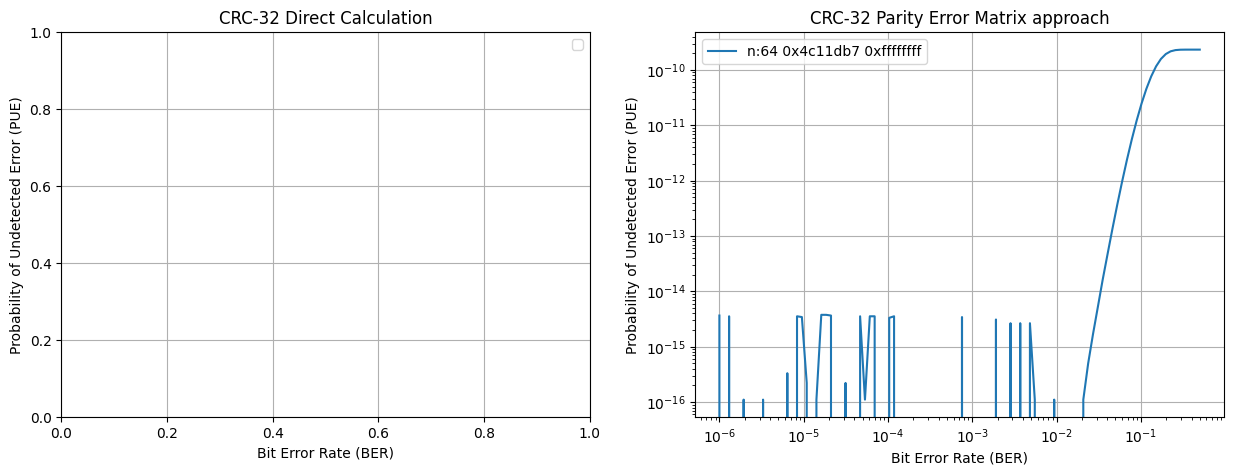

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Weight:  [0, 0, 0, 0, 0, 0, 1, 0, 4, 0, 64, 0, 1537, 0, 22006, 0, 227550, 0, 1679483, 0, 9135753, 0, 37402037, 0, 116735528, 0, 280122312, 0, 520951118, 0, 754516952, 0, 853397641, 0, 754452646, 0, 521023622, 0, 280109439, 0, 116703532, 0, 37417200, 0, 9143777, 0, 1673554, 0, 227520, 0, 22375, 0, 1601, 0, 43, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
PUE(0.01)=  5.584943518880818e-13
PUE(0.001)=  9.436263458392701e-19
adding  n:64 0xf1922815 0xffffffff  to subplot 0,  0
PUE direct:  [9.99942001656967e-37, 2.2149471196771375e-36, 4.906269582235977e-36, 1.086773087153609e-35, 2.4072748740979164e-35, 5.332265160750727e-35, 1.1811279117158977e-34, 2.6162614727362453e-34, 5.795144082037063e-34, 1.283648301942159e-33, 2.843324335091259e-33, 6.298035223276405e-33, 1.3950245923171166e-32, 3.089985685196756e-32, 6.844292925794317e-32, 1.51599536883973e-31, 3.357870353629492e-31, 7.437488005892563e-31, 1.6473444364017752e-30, 3.648696427959369e-30, 8.081380393537121e-30, 1.7898930774133714e-29, 3.9642538590

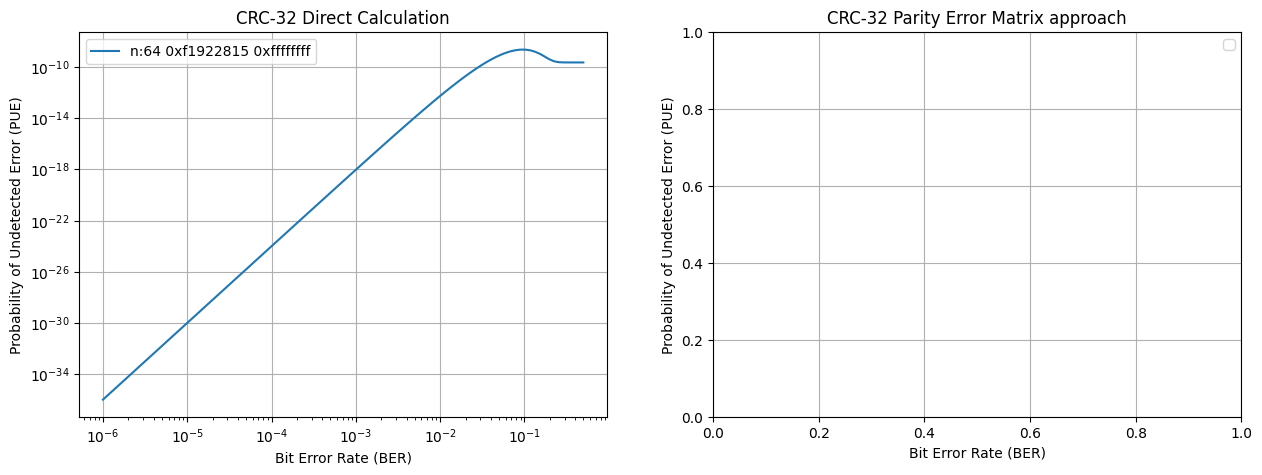

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Weight:  [1, 0, 0, 0, 0, 0, 0, 0, 0, 9, 37, 139, 759, 2747, 11237, 37500, 114822, 319756, 839513, 2031411, 4564667, 9574379, 18698953, 34164581, 58361240, 93370858, 140081778, 197116378, 260491854, 323335490, 377206626, 413788576, 426740674, 413788576, 377206626, 323335490, 260491854, 197116378, 140081778, 93370858, 58361240, 34164581, 18698953, 9574379, 4564667, 2031411, 839513, 319756, 114822, 37500, 11237, 2747, 759, 139, 37, 9, 0, 0, 0, 0, 0, 0, 0, 0, 1]
PUE(0.01)=  0.0
PUE(0.001)=  3.3306690738754696e-16
PUE Matrix:  [3.774758283725532e-15, 0.0, 3.6637359812630166e-15, 0.0, 2.220446049250313e-16, 0.0, 0.0, -3.4416913763379853e-15, 1.1102230246251565e-16, -1.1102230246251565e-16, -3.3306690738754696e-16, 1.1102230246251565e-16, 0.0, -1.1102230246251565e-16, 1.1102230246251565e-16, 1.1102230246251565e-16, 3.4416913763379853e-15, 3.3306690738754696e-15, 1.1102230246251565e-16, -3.3306690738754696e-15, 0.0, 3.552713678800501e-15, 3.6637359812630166e-15, 3.1086244689504383e-15, 1.11022

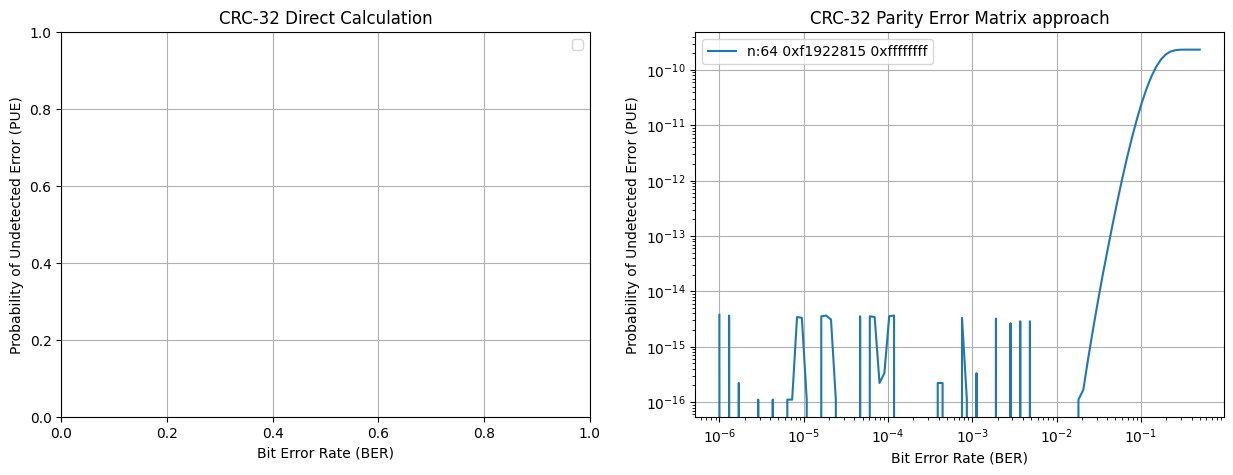

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Weight:  [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 80, 0, 1555, 0, 22193, 0, 228041, 0, 1676817, 0, 9129422, 0, 37433904, 0, 116697628, 0, 280124724, 0, 520986154, 0, 754490894, 0, 853361287, 0, 754537582, 0, 520971664, 0, 280107548, 0, 116705850, 0, 37428596, 0, 9139531, 0, 1671337, 0, 228303, 0, 22665, 0, 1434, 0, 76, 0, 8, 0, 0, 0, 0, 0, 0, 0, 1]
PUE(0.01)=  1.143860970336492e-16
PUE(0.001)=  1.8911010810017618e-24
adding  n:64 0xf4acfb13 0xffffffff  to subplot 0,  0
PUE direct:  [1.9998880031599365e-48, 5.774641887162475e-48, 1.6674159432114683e-47, 4.814622986078748e-47, 1.3902086398323902e-46, 4.0141810312707356e-46, 1.1590791545123824e-45, 3.346788656896975e-45, 9.663676857947399e-45, 2.7903281113176534e-44, 8.056877099447569e-44, 2.326358236671823e-43, 6.717143208336106e-43, 1.9395032989189218e-42, 5.6000775421065024e-42, 1.616943412996564e-41, 4.668662476224069e-41, 1.3479896748268398e-40, 3.89203359484696e-40, 1.1237299192786463e-39, 3.2444568144569484e-39, 9.367333639022546e-39, 2.7044

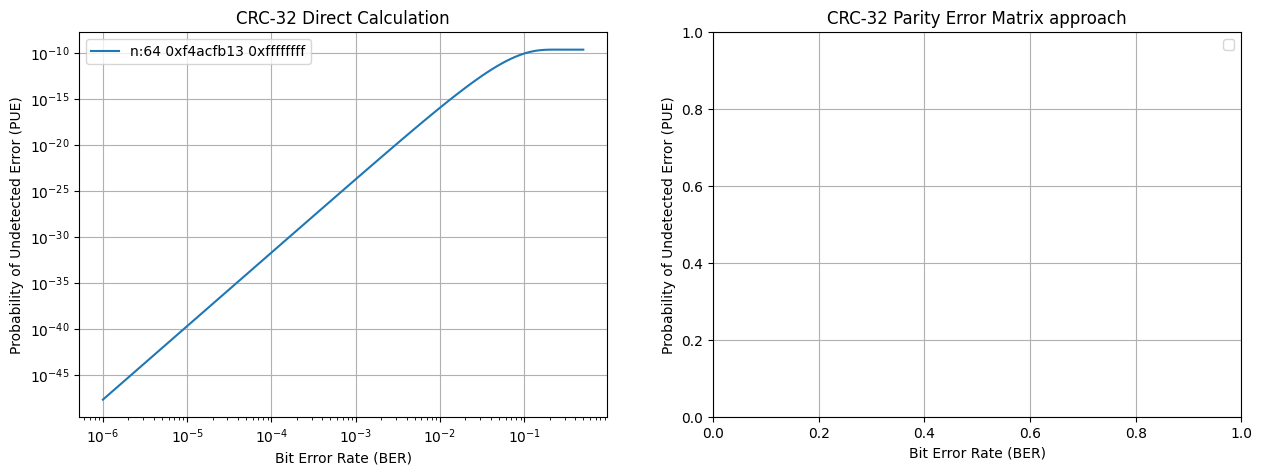

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Weight:  [1, 0, 0, 0, 0, 0, 0, 0, 3, 10, 44, 162, 722, 3136, 11632, 37628, 113305, 320716, 835520, 2025120, 4572722, 9578906, 18706988, 34166082, 58361169, 93361540, 140061192, 197134068, 260465212, 323337200, 377271920, 413777256, 426682788, 413777256, 377271920, 323337200, 260465212, 197134068, 140061192, 93361540, 58361169, 34166082, 18706988, 9578906, 4572722, 2025120, 835520, 320716, 113305, 37628, 11632, 3136, 722, 162, 44, 10, 3, 0, 0, 0, 0, 0, 0, 0, 1]
PUE(0.01)=  5.551115123125783e-16
PUE(0.001)=  -1.1102230246251565e-16
PUE Matrix:  [3.6637359812630166e-15, 0.0, 3.774758283725532e-15, -1.1102230246251565e-16, 0.0, -2.220446049250313e-16, 0.0, -3.6637359812630166e-15, 4.440892098500626e-16, -2.220446049250313e-16, 0.0, 1.1102230246251565e-16, 1.1102230246251565e-16, -1.1102230246251565e-16, 0.0, -1.1102230246251565e-16, 3.3306690738754696e-15, 3.6637359812630166e-15, 0.0, -3.552713678800501e-15, -1.1102230246251565e-16, 3.6637359812630166e-15, 3.552713678800501e-15, 3.44169137

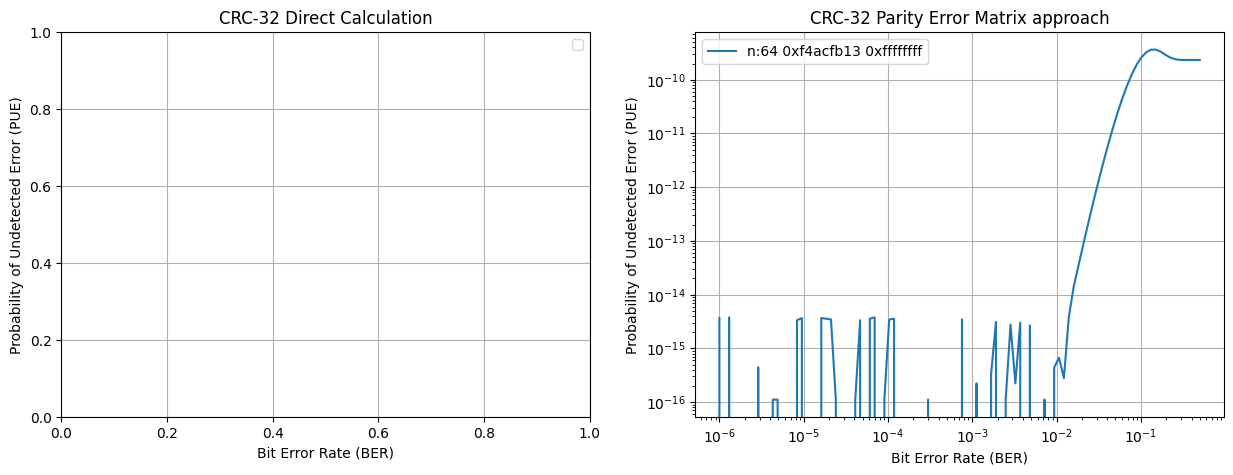

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Weight:  [0, 0, 2, 0, 13, 0, 60, 0, 103, 0, 66, 0, 11, 0, 0, 0, 1]
PUE(0.01)=  0.00017386444685954814
PUE(0.001)=  1.972194118912551e-06
adding  n:16 0x2f 0xffffffff  to subplot 0,  0
PUE direct:  [1.999972000194998e-12, 2.6070764158486543e-12, 3.3984703415050946e-12, 4.430095291121578e-12, 5.774873728801674e-12, 7.527863495652065e-12, 9.81297676589901e-12, 1.2791738389137053e-11, 1.6674702588434124e-11, 2.173633482690673e-11, 2.833441049479219e-11, 3.6935301194634686e-11, 4.8146935346136136e-11, 6.276176195766329e-11, 8.18127529818393e-11, 1.0664640054725541e-10, 1.3901786550236964e-10, 1.8121499776388527e-10, 2.3621998720275775e-10, 3.079200598771656e-10, 4.0138209544785294e-10, 5.232105512898817e-10, 6.820139545107651e-10, 8.890128780324113e-10, 1.1588322890688933e-09, 1.5105341479770345e-09, 1.9689630538336657e-09, 2.5664997657830735e-09, 3.3453461182539064e-09, 4.360502198632001e-09, 5.6836452740455275e-09, 7.408183225589004e-09, 9.655837570718251e-09, 1.2585218234745148e-08, 1.64

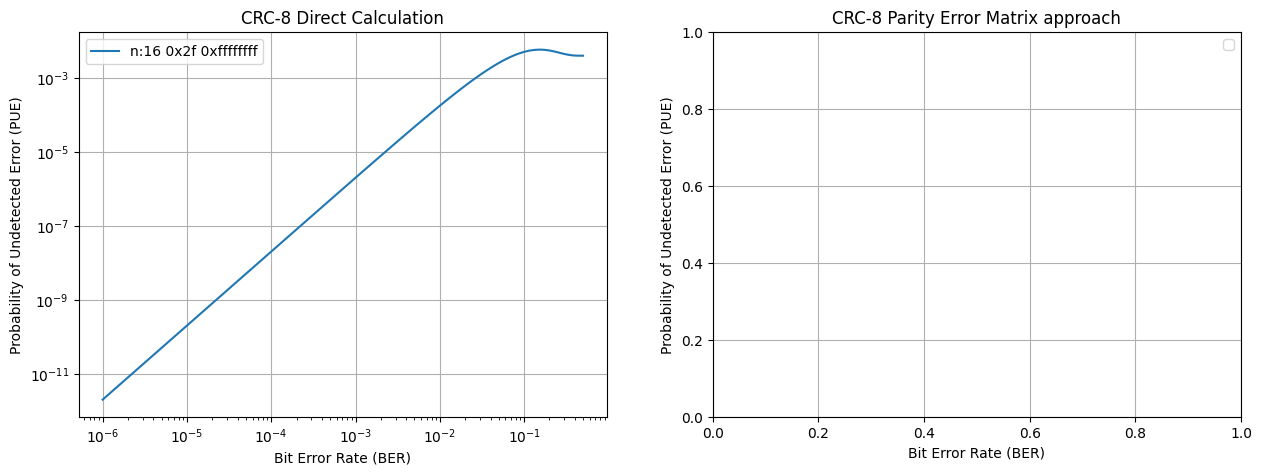

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Weight:  [1, 0, 0, 0, 8, 16, 32, 48, 46, 48, 32, 16, 8, 0, 0, 0, 1]
PUE(0.01)=  9.756203467325975e-08
PUE(0.001)=  1.0868861366475357e-11
PUE Matrix:  [9.992007221626409e-16, 0.0, 9.992007221626409e-16, 0.0, 0.0, 0.0, -1.1102230246251565e-16, -7.771561172376096e-16, 0.0, 1.1102230246251565e-16, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.881784197001252e-16, 9.992007221626409e-16, 0.0, -8.881784197001252e-16, 0.0, 8.881784197001252e-16, 6.661338147750939e-16, 7.771561172376096e-16, 0.0, -8.881784197001252e-16, -1.1102230246251565e-16, -8.881784197001252e-16, 0.0, 8.881784197001252e-16, 2.220446049250313e-16, 1.1102230246251565e-15, 1.2212453270876722e-15, 3.3306690738754696e-16, 6.661338147750939e-16, 2.1094237467877974e-15, 2.9976021664879227e-15, 2.6645352591003757e-15, 5.329070518200751e-15, 9.658940314238862e-15, 1.765254609153999e-14, 2.942091015256665e-14, 5.051514762044462e-14, 8.72635297355373e-14, 1.474376176702208e-13, 2.5202062658991053e-13, 4.277689313880728e-13, 7.251976796851523e-13,

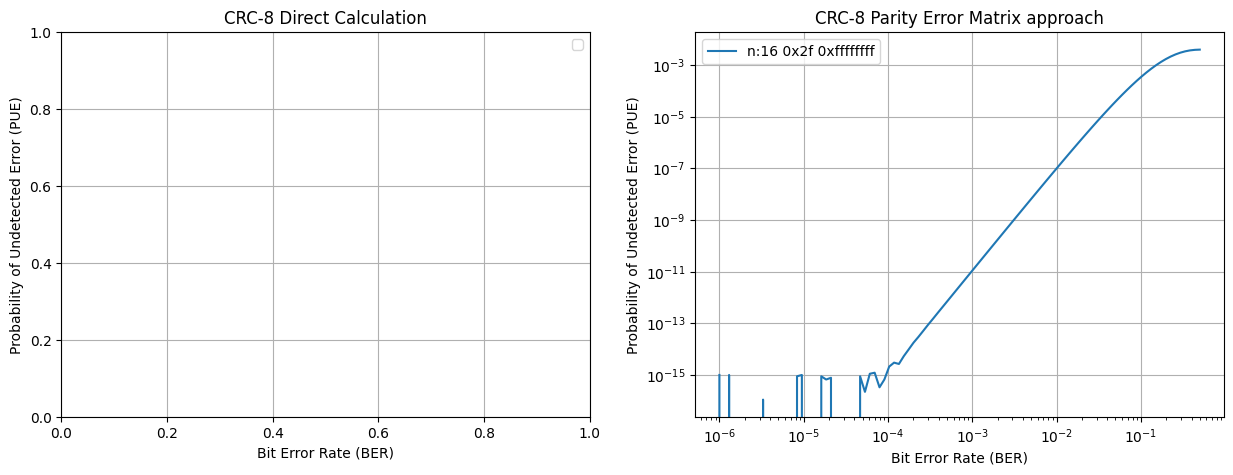

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Weight:  [1, 0, 0, 0, 19, 0, 42, 0, 127, 0, 52, 0, 13, 0, 2, 0, 0]
PUE(0.01)=  1.684511213925621e-07
PUE(0.001)=  1.8773291411400927e-11
adding  n:16 0x31 0x0  to subplot 0,  0
PUE direct:  [1.8999772001295983e-23, 3.2285615111269596e-23, 5.486174738116532e-23, 9.322450530799323e-23, 1.5841284818182364e-22, 2.6918481768951106e-22, 4.574151479741454e-22, 7.772671636410068e-22, 1.3207781240869698e-21, 2.244342577592934e-21, 3.813714058037448e-21, 6.4804738379172696e-21, 1.1011969544064941e-20, 1.8712111281370973e-20, 3.1796554925504556e-20, 5.403022270240804e-20, 9.181058988660829e-20, 1.5600841815333048e-19, 2.6509553685685677e-19, 4.504595535410889e-19, 7.654345302330855e-19, 1.3006456690589987e-18, 2.210082393377224e-18, 3.755400301828937e-18, 6.38119586776351e-18, 1.08429063314476e-17, 1.8424122655797206e-17, 3.130581745311709e-17, 5.3193674936296504e-17, 9.038392353784386e-17, 1.535741434322343e-16, 2.6093967852157937e-16, 4.433600533455641e-16, 7.53297668595195e-16, 1.2798804555939

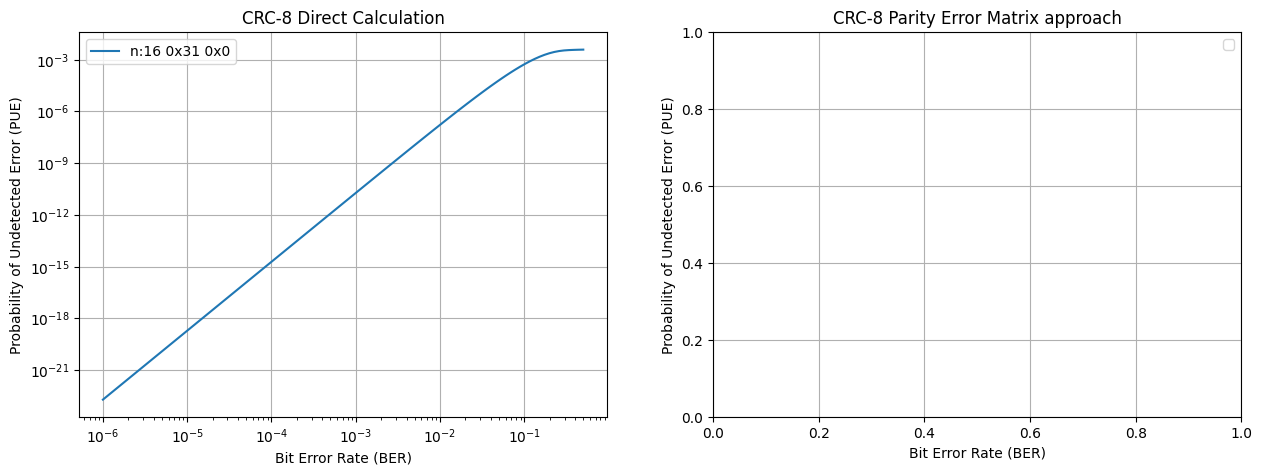

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Weight:  [1, 0, 0, 2, 12, 10, 16, 52, 70, 52, 16, 10, 12, 2, 0, 0, 1]
PUE(0.01)=  1.6845112138508256e-07
PUE(0.001)=  1.8773205212596622e-11
PUE Matrix:  [8.881784197001252e-16, 0.0, 8.881784197001252e-16, 0.0, 0.0, 1.1102230246251565e-16, 0.0, -9.992007221626409e-16, 1.1102230246251565e-16, 1.1102230246251565e-16, 0.0, -1.1102230246251565e-16, 0.0, 0.0, 0.0, 1.1102230246251565e-16, 8.881784197001252e-16, 1.1102230246251565e-15, 0.0, -8.881784197001252e-16, -1.1102230246251565e-16, 8.881784197001252e-16, 9.992007221626409e-16, 8.881784197001252e-16, 1.1102230246251565e-16, -7.771561172376096e-16, 0.0, -9.992007221626409e-16, 1.1102230246251565e-16, 1.1102230246251565e-15, 2.220446049250313e-16, 1.2212453270876722e-15, 1.4432899320127035e-15, 7.771561172376096e-16, 1.4432899320127035e-15, 2.886579864025407e-15, 4.440892098500626e-15, 5.329070518200751e-15, 9.992007221626409e-15, 1.7541523789077473e-14, 3.0753177782116836e-14, 5.129230373768223e-14, 8.79296635503124e-14, 1.50768286744096

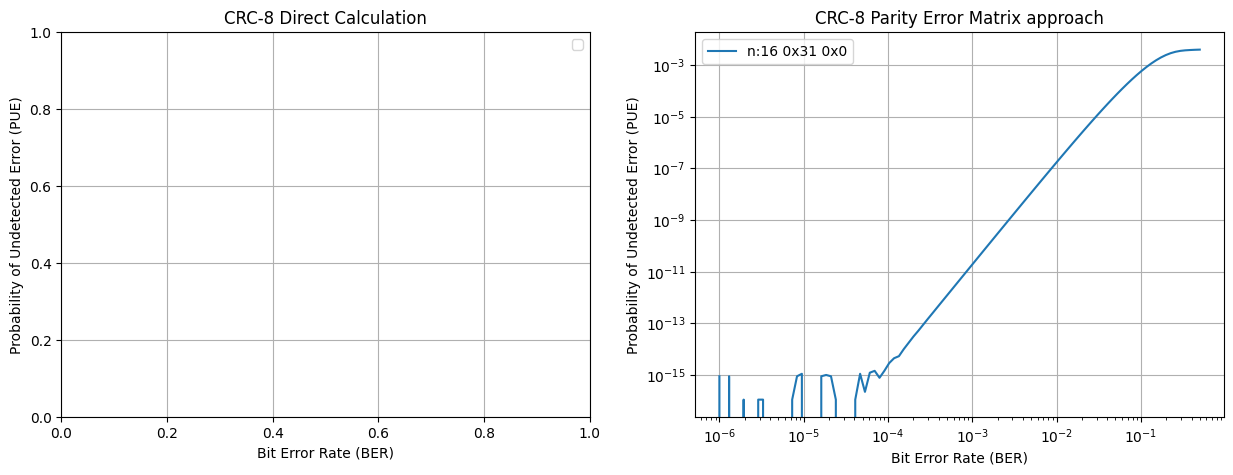

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Weight:  [0, 0, 2, 0, 13, 0, 52, 0, 127, 0, 42, 0, 19, 0, 0, 0, 1]
PUE(0.01)=  0.00017386443962670592
PUE(0.001)=  1.9721941189046303e-06
adding  n:16 0x31 0xffffffff  to subplot 0,  0
PUE direct:  [1.999972000194998e-12, 2.6070764158486543e-12, 3.3984703415050946e-12, 4.430095291121578e-12, 5.774873728801674e-12, 7.527863495652065e-12, 9.81297676589901e-12, 1.2791738389137053e-11, 1.6674702588434124e-11, 2.173633482690673e-11, 2.833441049479219e-11, 3.6935301194634686e-11, 4.8146935346136136e-11, 6.276176195766329e-11, 8.18127529818393e-11, 1.0664640054725541e-10, 1.3901786550236964e-10, 1.8121499776388527e-10, 2.3621998720275775e-10, 3.079200598771656e-10, 4.0138209544785294e-10, 5.232105512898817e-10, 6.820139545107651e-10, 8.890128780324113e-10, 1.1588322890688933e-09, 1.5105341479770345e-09, 1.9689630538336657e-09, 2.5664997657830735e-09, 3.3453461182539064e-09, 4.360502198632001e-09, 5.683645274045527e-09, 7.408183225589003e-09, 9.655837570718251e-09, 1.2585218234745146e-08, 1.64

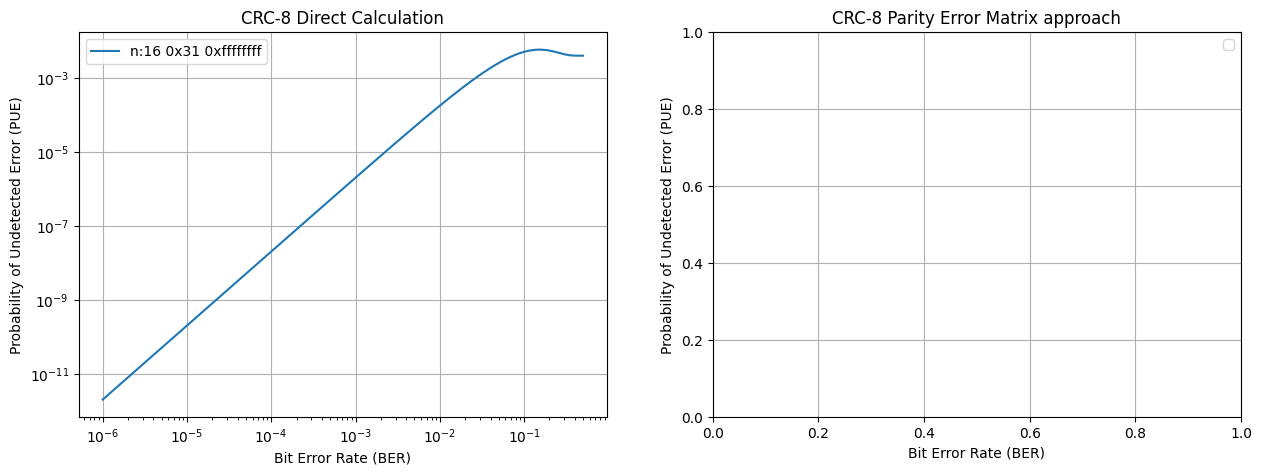

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Weight:  [1, 0, 0, 2, 12, 10, 16, 52, 70, 52, 16, 10, 12, 2, 0, 0, 1]
PUE(0.01)=  1.6845112138508256e-07
PUE(0.001)=  1.8773205212596622e-11
PUE Matrix:  [8.881784197001252e-16, 0.0, 8.881784197001252e-16, 0.0, 0.0, 1.1102230246251565e-16, 0.0, -9.992007221626409e-16, 1.1102230246251565e-16, 1.1102230246251565e-16, 0.0, -1.1102230246251565e-16, 0.0, 0.0, 0.0, 1.1102230246251565e-16, 8.881784197001252e-16, 1.1102230246251565e-15, 0.0, -8.881784197001252e-16, -1.1102230246251565e-16, 8.881784197001252e-16, 9.992007221626409e-16, 8.881784197001252e-16, 1.1102230246251565e-16, -7.771561172376096e-16, 0.0, -9.992007221626409e-16, 1.1102230246251565e-16, 1.1102230246251565e-15, 2.220446049250313e-16, 1.2212453270876722e-15, 1.4432899320127035e-15, 7.771561172376096e-16, 1.4432899320127035e-15, 2.886579864025407e-15, 4.440892098500626e-15, 5.329070518200751e-15, 9.992007221626409e-15, 1.7541523789077473e-14, 3.0753177782116836e-14, 5.129230373768223e-14, 8.79296635503124e-14, 1.50768286744096

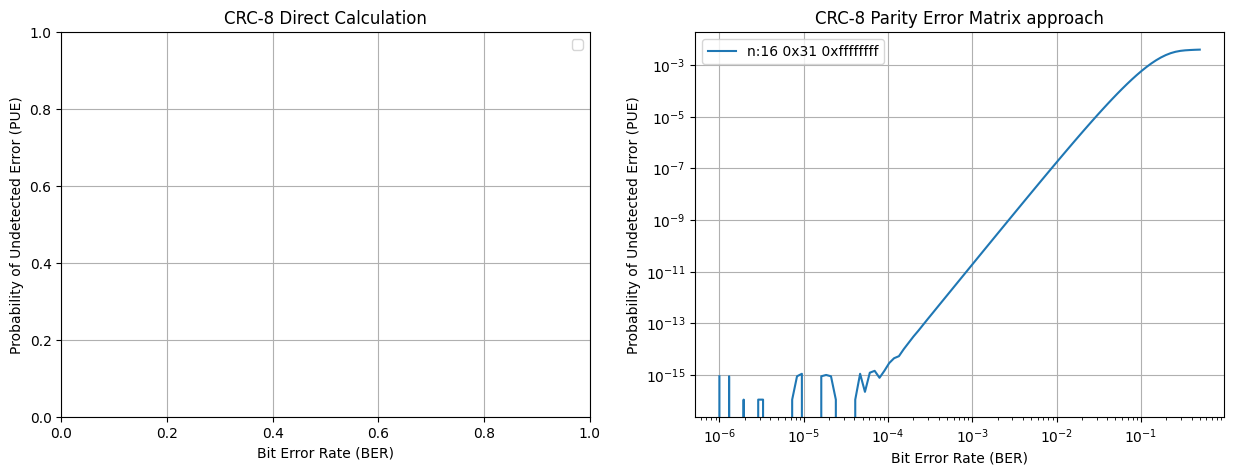

In [81]:
# @brief Plot the PUE vs BER
# @param data The data to plot
# @param Pe_list The list of BER values
def plot_data(data, Pe_list):
    print("Weight: ", data['Data'])
    R_01 = get_single_PUE(data, 0.01)
    R_001 = get_single_PUE(data, 0.001)
    print("PUE(0.01)= ", R_01)
    print("PUE(0.001)= ", R_001)

    fig, axs = plt.subplots(1,2 , figsize=(15, 5))
    
    axs[0].set_title('CRC-{} Direct Calculation'.format(data["CRC"]))
    axs[1].set_title('CRC-{} Parity Error Matrix approach'.format(data["CRC"]))
        
    
    if data['Method'] == 'direct':
        col = 0
        print("adding ", data['label'] , " to subplot 0, ", col)
        axs[col].loglog(Pe_list, data['PUE'], label=data['label'] )
        print("PUE direct: ", data['PUE'])
    elif data['Method'] == 'direct_parityMatrix':
        col = 1
        axs[col].loglog(Pe_list, data['PUE'], label=data['label'] )
        print("PUE Matrix: ", data['PUE'])
    else: 
        assert False, "Method not known"
        col = 10

    # all subplots shall have the same x-axis label
    for ax in axs.flat:
        ax.set(xlabel='Bit Error Rate (BER)', ylabel='Probability of Undetected Error (PUE)')
        ax.grid(True)
        ax.legend() 

    plt.show()

# define the plot
#ax = define_plot()

# define the BER range
Pe_list = define_BER_range()

# get raw data 
raw_data = get_data('data') 

for raw in raw_data:
    # calculate the Probability of Undetected Error (PUE)
    data, key_points = get_PUE(raw, Pe_list) 
    plot_data(data, Pe_list)

## Explanation

## Direct approach via Error-Check-Matrix

**Parity Check Matrix $H$**

For a linear block code, the parity check matrix $H$ has dimensions $(n-k) \times n$, where $n$ is the total number of bits in each codeword, and $k$ is the number of message bits. The matrix $H$ ensures that for any valid codeword $c$, $Hc^T = 0$.

#### 1. **Binary Vector Operations**

Each row of $H$ represents a constraint that any valid codeword must satisfy. A binary vector operation in this context involves:
- **XOR Operation**: Logical XOR operation between two binary vectors (rows) is defined as:
  $$[v_1 \oplus v_2]_i = v_{1i} \oplus v_{2i} \quad \text{for all } i \text{ from } 1 \text{ to } n$$
  where $v_{1i}$ and $v_{2i}$ are the $i$-th bits of vectors $v_1$ and $v_2$ respectively, and $\oplus$ denotes the XOR operation.

#### 2. **Generating All Row Combinations**

We consider all possible subsets of rows from $H$. The number of such subsets (excluding the empty set) is $2^{n-k} - 1$. For each subset:
- **Subset Selection**: A subset of rows $R \subset \{1, 2, ..., n-k\}$ is selected. The selection can be represented as a binary number where each bit position indicates whether a row is included.
- **Vector Combination**: The corresponding rows are combined using XOR:
  $$v = \bigoplus_{i \in R} H_i$$
  where $H_i$ is the $ i $-th row of $ H $, and $ \bigoplus $ denotes the XOR operation applied across multiple vectors.

#### 3. **Calculating the Weight of Each Vector**

For each resultant vector $v$ from the combination process:
- **Weight Calculation**: The weight $w(v)$ of a vector $v$ is the number of 1's in $v$:
  $$w(v) = \sum_{i=1}^n v_i$$
  where $v_i$ is the $i$-th bit of vector $v$.

#### 4. **Building the Weight Distribution**

For every vector $v$ calculated:
- **Distribution Tallying**: Increase the count of vectors that have weight $w(v)$ in a distribution array $D$ where $D[w]$ represents the number of vectors of weight $w$:
  $$D[w(v)] = D[w(v)] + 1$$
- The array $D$ will be of size $n+1$ to account for all possible weights from 0 to $n$.

### Summary of Formulas and Steps

1. **Vector XOR**: $[v_1 \oplus v_2]_i = v_{1i} \oplus v_{2i}$.
2. **Vector Combination**: $v = \bigoplus_{i \in R} H_i$.
3. **Weight Calculation**: $w(v) = \sum_{i=1}^n v_i$.
4. **Distribution Update**: $D[w(v)] = D[w(v)] + 1$.

These steps will calculate the weight distribution for a parity check matrix, reflecting the number of vectors at each weight level that can arise from different combinations of rows, providing insights into the error detection and correction capabilities of the code.